In [136]:
import numpy as np 
import pickle
import random
import matplotlib.pyplot as plt
import itertools


# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# NLTK
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams

# Preprocessing and feature extraction

## Read data from files and split into train, validation & test

In [137]:
pos_reviews = []
neg_reviews = []

for sentiment, review_list in zip(['pos', 'neg'],[pos_reviews, neg_reviews]):
    with open('rt-polaritydata/rt-polarity.%s'%sentiment, encoding='utf-8', errors='replace') as infile:
        for line in infile:
            review_list.append(line.rstrip())
            
random.shuffle(pos_reviews)
random.shuffle(neg_reviews)

training_set = []
validation_set = []
testing_set = []

for i, (p, n) in enumerate(zip(pos_reviews, neg_reviews)):
    if i < 4000:
        training_set.extend(((p, 'pos'), (n, 'neg')))
    elif i >= 4000 and i <4750:
        validation_set.extend(((p, 'pos'), (n, 'neg')))
    else:
        testing_set.extend(((p, 'pos'), (n, 'neg')))
        
for setname, s in zip(['training', 'validation', 'testing'], [training_set, validation_set, testing_set]):
    print('# examples in %s set: %s'%(setname, len(s)))

# examples in training set: 8000
# examples in validation set: 1500
# examples in testing set: 1162


## Remove Stop Words & Punctuation

In [138]:
stop_words = set(stopwords.words('english'))

# Calling tokenize() on this object will return list of tokens without punctuation.
regex_tokenizer = RegexpTokenizer(r'\w+')

def preprocess(sentence, remove_stopwords=True):
    tokens = regex_tokenizer.tokenize(sentence.lower())
    if remove_stopwords:
        filtered_words = [w for w in tokens if not w in stop_words]
        return ' '.join(filtered_words)
    else:
        return ' '.join(tokens)

## Unigrams, Bigrams and Deciding which features to include

In [139]:
all_training_words = word_tokenize(' '.join([preprocess(review[0]) for review in training_set]))

unigrams = ngrams(all_training_words, 1)
bigrams = ngrams(all_training_words, 2)

unigram_fdist = nltk.FreqDist(unigrams)
bigram_fdist = nltk.FreqDist(bigrams)

unigram_features = [f[0] for f in unigram_fdist.most_common(3000)]
bigram_features = [f[0] for f in bigram_fdist.most_common(1000)]

## Feature extraction functions


In [140]:
def get_features(sentence, bigrams=True, counts=False):
    features = []
    word_tokens = word_tokenize(sentence)

    if counts==True:
        word_tokens = word_tokenize(sentence)

        sentence_unigrams = [tok for tok in ngrams(word_tokens, 1)]
        sentence_fdist = nltk.FreqDist(sentence_unigrams)   
        for feature in unigram_features:
            if feature in sentence_fdist:
                features.append(sentence_fdist[feature])
            else:
                features.append(0)
        if bigrams:
            sentence_bigrams = [tok for tok in ngrams(word_tokens, 2)]
            sentence_fdist = nltk.FreqDist(sentence_bigrams)
            for feature in bigram_features:
                if feature in sentence_fdist:
                    features.append(sentence_fdist[feature])
                else:
                    features.append(0)
    else:
        sentence_unigrams = [tok for tok in ngrams(word_tokens, 1)]
        for feature in unigram_features:
            if feature in sentence_unigrams:
                features.append(1)
            else:
                features.append(0)
        if bigrams:
            sentence_bigrams = [tok for tok in ngrams(word_tokens, 2)]
            for feature in bigram_features:
                if feature in sentence_bigrams:
                    features.append(1)
                else:
                    features.append(0)
        
    return np.array(features)

def get_matrixform(setname, bigrams=True, counts=False):
    #Function to transform list of (reviews, sentiments) into matrix using get_features()
    X = []
    y = []
    for (Xi,yi) in setname:
        X.append(get_features(Xi, bigrams=bigrams, counts=counts))
        y.append(1 if yi == 'pos' else 0)
    return np.array(X), np.array(y)

## Visualizing features (features $\in \left\{0,1\right\}$ representing presence of an N-gram for $N \leq 2$) 

In [141]:
# Build matrices
X_train,y_train = get_matrixform(training_set, bigrams=True, counts=False)
X_val, y_val = get_matrixform(validation_set, bigrams=True, counts=False)
X_test, y_test = get_matrixform(testing_set, bigrams=True, counts=False)

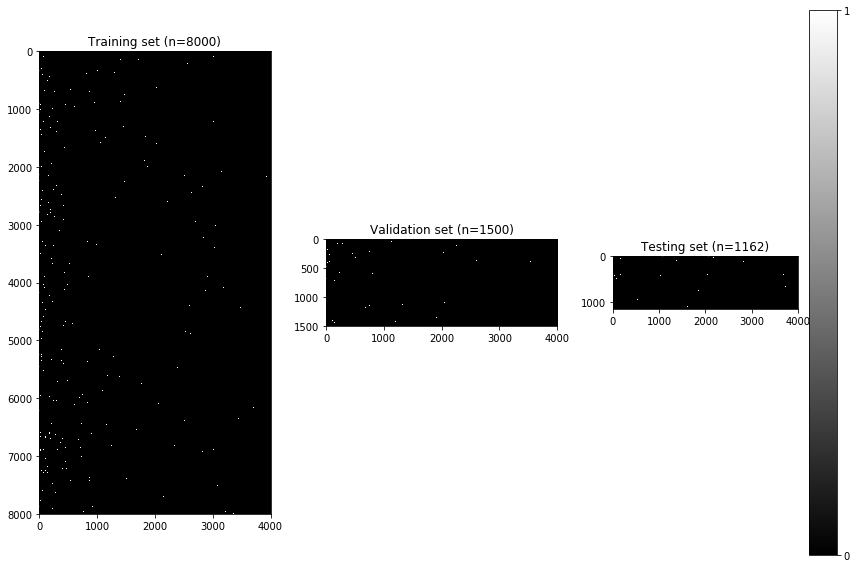

<Figure size 432x288 with 0 Axes>

In [142]:
# Visualize features
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(12,8))
plot1 = ax1.imshow(X_train, cmap='gray');
ax1.set_title("Training set (n=%s)"%len(training_set))

plot2 = ax2.imshow(X_val, cmap='gray');
ax2.set_title("Validation set (n=%s)"%len(validation_set))

plot3 = ax3.imshow(X_test, cmap='gray');
ax3.set_title("Testing set (n=%s)"%len(testing_set))

plt.colorbar(plot3, ax=ax3, ticks=[0,1])
plt.tight_layout()
plt.show()
plt.clf()

## Visualizing features (features $\in \mathbb{Z}^+$ representing N-gram  counts for $N \leq 2$) 

In [143]:
# Build matrices
X_train,y_train = get_matrixform(training_set, bigrams=True, counts=True)
X_val, y_val = get_matrixform(validation_set, bigrams=True, counts=True)
X_test, y_test = get_matrixform(testing_set, bigrams=True, counts=True)

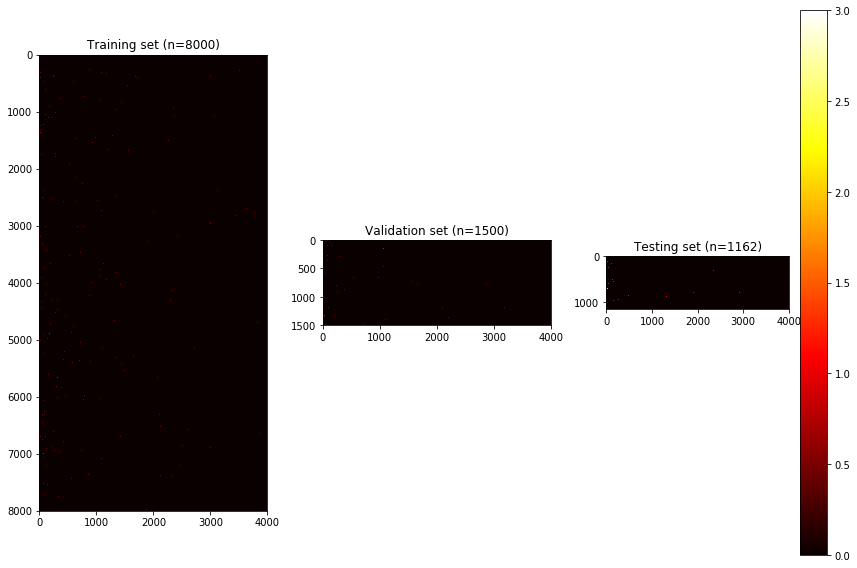

<Figure size 432x288 with 0 Axes>

In [144]:
# Visualize features
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(12,8))
plot1 = ax1.imshow(X_train, cmap='hot');
ax1.set_title("Training set (n=%s)"%len(training_set))

plot2 = ax2.imshow(X_val, cmap='hot');
ax2.set_title("Validation set (n=%s)"%len(validation_set))

plot3 = ax3.imshow(X_test, cmap='hot');
ax3.set_title("Testing set (n=%s)"%len(testing_set))

plt.colorbar(plot3, ax=ax3)
plt.tight_layout()
plt.show()
plt.clf()

# Comparing Logistic Regression, SVM (linear kernel) and Naive Bayes

## Logistic Regression

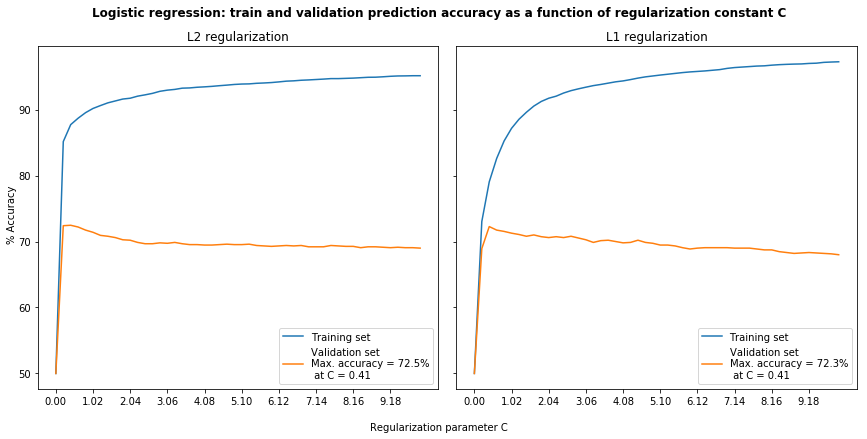

In [145]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12,6))
for penalty, ax in zip(['l2', 'l1'], [ax1, ax2]):
    training_accuracies = []
    validation_accuracies = []
    regularization_constants = np.linspace(1e-30, 10, 50)
    for c in regularization_constants:
        log_reg = LogisticRegression(penalty=penalty, C=c)
        log_reg.fit(X_train, y_train)
        training_accuracies.append(log_reg.score(X_train, y_train)*100)
        validation_accuracies.append(log_reg.score(X_val, y_val)*100)

    optimal_c = regularization_constants[validation_accuracies.index(max(validation_accuracies))]
    ax.plot(training_accuracies, label='Training set')
    ax.plot(validation_accuracies, label='Validation set\nMax. accuracy = %0.1f%%\n at C = %0.2f'%(max(validation_accuracies), optimal_c))
    ax.set_xticks([i for i in range(len(regularization_constants))][::5])
    ax.set_xticklabels(['%0.2f'%r for r in regularization_constants][::5])
    ax.set_title(penalty.upper() + ' regularization')
    ax.legend()
    
plt.suptitle('Logistic regression: train and validation prediction accuracy as a function of regularization constant C', fontweight='bold')
f.text(0.5, 0, 'Regularization parameter C', ha='center')
f.text(0, 0.5, '% Accuracy', va='center', rotation='vertical')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Multinomial Naive Bayes
- Use when when features are *word vector counts*.

- To predict the class of a given review, we compute:


$$
\hat{y} = \underset{y \in \{0,1\}}{\operatorname{argmax}} \prod_{i=1}^p P(x_i|y) 
$$


- In Multinomial Naive Bayes, $P(x_i|y) = \theta_{yi}$ where $\theta_{yi}$ is an element of $\theta{y} = (\theta_{y1}, ..., \theta_{yp})$

- In the case of binary classification, we have $\theta_0$ and $\theta_1$.

- $\theta_{y}$ is estimated by estimating each $\theta_{yi}$ as follows:

$$
\hat{\theta}_{yi} = \frac{N_{yi} + \alpha}{N_y + \alpha p}
$$

- Where:

$$
N_{yi} = \sum_{x\in T} x_i \text{    } \leftarrow \text{Number times feature } i \text{ appears for sentiment } y \text{ in training set } T.
\\
N_{y} = \sum_{i=1}^{|T|} N_{yi} \text{    } \leftarrow \text{Total count of all features for sentiment } y \text{ in training set } T.
$$


- Smoothing parameter $\alpha$: 
    - $\alpha$ accounts for features that are not present in the learning samples and prevents zero probabilities.
    - $\alpha$ must be $\geq 0$
    - $\alpha = 1$ corresponds to Laplace smoothing. 
    - $\alpha < 1$ corresponds to Lidstone smoothing. 

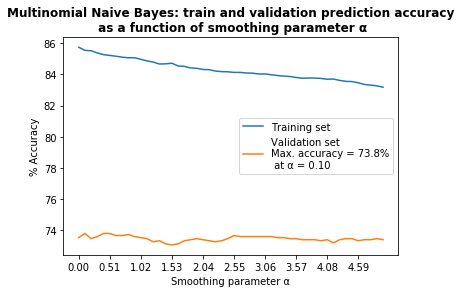

In [146]:
# Multinomial Naive Bayes
training_accuracies = []
validation_accuracies = []
alphas = np.linspace(1e-10,5,50)
for alpha in alphas:
    mnb = MultinomialNB(alpha=alpha)
    mnb.fit(X_train, y_train)
    training_accuracies.append(mnb.score(X_train, y_train)*100)
    validation_accuracies.append(mnb.score(X_val, y_val)*100)

optimal_alpha = alphas[validation_accuracies.index(max(validation_accuracies))]
plt.plot(training_accuracies, label='Training set')
plt.plot(validation_accuracies, label='Validation set\nMax. accuracy = %0.1f%%\n at α = %0.2f'%(max(validation_accuracies), optimal_alpha))
plt.xticks([i for i in range(len(alphas))][::5], ['%0.2f'%r for r in alphas][::5])
plt.legend()
plt.title('Multinomial Naive Bayes: train and validation prediction accuracy\n as a function of smoothing parameter α', fontweight='bold')
plt.xlabel('Smoothing parameter α')
plt.ylabel('% Accuracy')
plt.show()

## Bernoulli Naive Bayes
- Use when we have multiple *binary valued features*.

- Decision rule for Bernoulli Naive Bayes:

$$
P(x_i|y) = P(i|y)x_i + (1-P(i|y))(1-x_i)
$$


- Where $x_i$ represents the occurence or non-occurence of a word, $P(i|y)$ represents the frequency of feature $i$ in the training set for sentiment $y$.
- To predict $\hat{y}$ for a new review, we must compute $P(x_i|y)$ for each feature in the feature set of size $p$.

$$
\hat{y} = \underset{y \in \{0,1\}}{\operatorname{argmax}} \prod_{i=1}^p P(x_i|y) 
$$


- In Bernoulli Naive Bayes, the decision rule will penalize the non-occurence of a word that is common in sentiment $y$.


- Given some $y \in \{0,1\}:$
\begin{array}{|c|c|c|}
\hline & x_i \text{ present } \rightarrow P(x_i|y) = P(i|y) & x_i \text{ not present } \rightarrow P(x_i|y) = 1-P(i|y) \\\hline
  \text{Common in } y & P(x_i|y) \text{ is large. The presence of } x_i \text{ contributes to } \hat{y} \text{ in favour of class } y & P(x_i|y) \text{ is small. The presence of } x_i \text{ contributes to } \hat{y} \text{ in disfavour of class } y\\\hline
  \text{Uncommon in }y & P(x_i|y) \text{ is small. The presence of } x_i \text{ contributes to } \hat{y} \text{ in disfavour of class } y & P(x_i|y) \text{ is large. The presence of } x_i \text{ contributes to } \hat{y} \text{ in favour of class } y \\\hline
\end{array}


- Multinomial Naive Bayes would simply ignore a non-occuring feature.



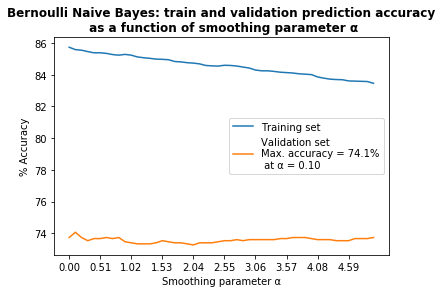

In [147]:
training_accuracies = []
validation_accuracies = []
alphas = np.linspace(1e-10,5,50)
for alpha in alphas:
    bnb = BernoulliNB(alpha=alpha)
    bnb.fit(X_train, y_train)
    training_accuracies.append(bnb.score(X_train, y_train)*100)
    validation_accuracies.append(bnb.score(X_val, y_val)*100)

optimal_alpha = alphas[validation_accuracies.index(max(validation_accuracies))]
plt.plot(training_accuracies, label='Training set')
plt.plot(validation_accuracies, label='Validation set\nMax. accuracy = %0.1f%%\n at α = %0.2f'%(max(validation_accuracies), optimal_alpha))
plt.xticks([i for i in range(len(alphas))][::5], ['%0.2f'%r for r in alphas][::5])
plt.legend()
plt.title('Bernoulli Naive Bayes: train and validation prediction accuracy\n as a function of smoothing parameter α', fontweight='bold')
plt.xlabel('Smoothing parameter α')
plt.ylabel('% Accuracy')
plt.show()

## Support Vector Machine (with linear kernel)

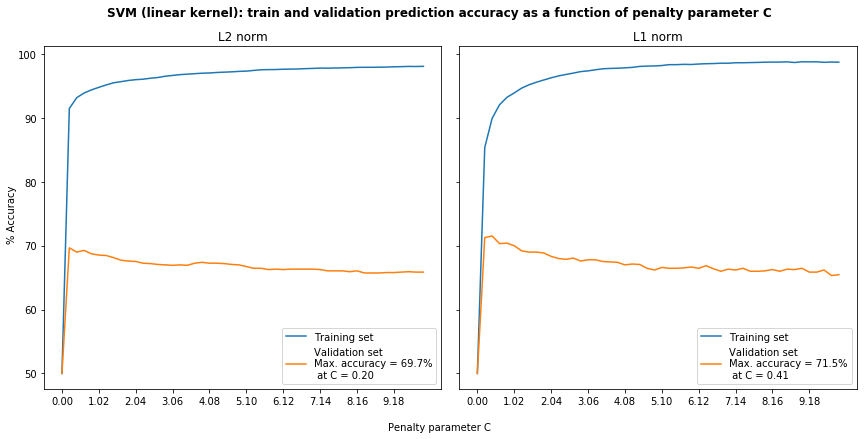

In [148]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12,6))
for penalty, ax in zip(['l2', 'l1'], [ax1, ax2]):
    training_accuracies = []
    validation_accuracies = []
    penalty_params = np.linspace(1e-30, 10, 50)
    for c in penalty_params:
        svm = LinearSVC(penalty=penalty, C=c, dual=False)
        svm.fit(X_train, y_train)
        training_accuracies.append(svm.score(X_train, y_train)*100)
        validation_accuracies.append(svm.score(X_val, y_val)*100)

    optimal_c = penalty_params[validation_accuracies.index(max(validation_accuracies))]
    ax.plot(training_accuracies, label='Training set')
    ax.plot(validation_accuracies, label='Validation set\nMax. accuracy = %0.1f%%\n at C = %0.2f'%(max(validation_accuracies), optimal_c))
    ax.set_xticks([i for i in range(len(penalty_params))][::5])
    ax.set_xticklabels(['%0.2f'%r for r in penalty_params][::5])
    ax.set_title(penalty.upper() + ' norm')
    ax.legend()
    
plt.suptitle('SVM (linear kernel): train and validation prediction accuracy as a function of penalty parameter C', fontweight='bold')
f.text(0.5, 0, 'Penalty parameter C', ha='center')
f.text(0, 0.5, '% Accuracy', va='center', rotation='vertical')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Function to plot confusion matrix

In [149]:
# Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Random classifier accuracy: 50.26%


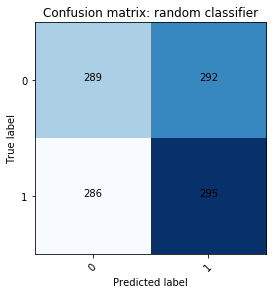

In [150]:
# Random classifier
y_pred_random = []
for review in X_test:
    y_pred_random.append(random.randint(0,1))
y_pred_random = np.array(y_pred)

# Accuracy
print('Random classifier accuracy: %0.2f%%'%(accuracy_score(y_test, y_pred_random)*100))

# Plot confusion matrix for random
cnf_matrix = confusion_matrix(y_test, y_pred_random)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes = ['0','1'], title='Confusion matrix: random classifier')

## Best performing model: Bernoulli Naive Bayes

Bernoulli Naive Bayes classifier accuracy (on test set): 71.08%


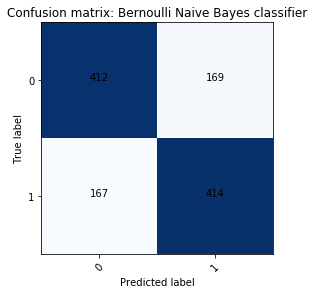

In [151]:
# We now test model on the testing set
y_pred_bnb = bnb.predict(X_test)

print('Bernoulli Naive Bayes classifier accuracy (on test set): %0.2f%%'%(accuracy_score(y_test, y_pred_bnb)*100))
# Plot confusion matrix for random
cnf_matrix = confusion_matrix(y_test, y_pred_bnb)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes = ['0','1'], title='Confusion matrix: Bernoulli Naive Bayes classifier')